In [1]:
# 分析时间：2013年1月1日-2022年12月31日，总共10年时间
# 但是在做特征分析的时候，可以把数据拉长。多搞一年：即2012-01-01至2022-12-31
feature_start_date_str = "2011-01-01"
start_date_str = "2012-01-01"
end_date_str = "2022-12-31"

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import QuantLib as ql
%matplotlib inline

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [3]:
def clean_data(raw_df, date_benchmark, feature_start_date, end_date):
    clean_df = raw_df[(raw_df['Date']>=feature_start_date) & (raw_df['Date']<=end_date)].reset_index(drop=True)
    investment_fac_df = pd.merge(date_benchmark, clean_df, on="Date", how="left")
    # 采用向下填充
    clean_df = clean_df.fillna(method='ffill')
    return clean_df

def plot_features(clean_df, col_name_list, title="Investment in fixed assets completed"):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for temp_col in col_name_list:
        ax.plot(clean_df['Date'], clean_df[temp_col], label=temp_col)
        

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    fig.autofmt_xdate()
    plt.tight_layout()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [4]:
feature_start_date = datetime.datetime.strptime(feature_start_date_str, "%Y-%m-%d")
start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.datetime.strptime(end_date_str, "%Y-%m-%d")
print(feature_start_date, start_date, end_date)

2011-01-01 00:00:00 2012-01-01 00:00:00 2022-12-31 00:00:00


In [5]:
# 取出目标数据
# 到期收益率
raw_yield_to_maturity_df = pd.read_excel('./data/国债到期收益率.xlsx')
raw_yield_to_maturity_df = raw_yield_to_maturity_df.rename(columns={'指标名称': 'Date',
       '国债到期收益率:6个月': "6M", '国债到期收益率:1年': "1Y", '国债到期收益率:2年': "2Y", '国债到期收益率:3年': "3Y",
       '国债到期收益率:4年': "4Y", '国债到期收益率:5年': "5Y", '国债到期收益率:6年': "6Y", '国债到期收益率:7年': "7Y", 
        '国债到期收益率:8年': "8Y",'国债到期收益率:9年': "9Y", '国债到期收益率:10年': "10Y", '国债到期收益率:15年': "15Y", 
        '国债到期收益率:20年': "20Y", '国债到期收益率:30年': "30Y"})
raw_yield_to_maturity_df

,Date,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y
0,2008-07-01,3.2769,3.4474,3.8065,4.0301,4.1697,4.3093,4.3498,4.3903,4.4292,4.4682,4.5072,4.9618,4.9639,4.9498
1,2008-07-02,3.4055,3.5461,3.8015,3.9506,4.0883,4.2260,4.3019,4.3778,4.4282,4.4787,4.5291,4.9442,4.9462,4.9501
2,2008-07-03,3.3343,3.4972,3.8687,3.9820,4.1085,4.2350,4.3163,4.3976,4.4436,4.4896,4.5356,4.9453,4.9469,4.9501
3,2008-07-04,3.3397,3.4763,3.8179,3.9854,4.1031,4.2209,4.3183,4.4157,4.4618,4.5080,4.5542,4.9469,4.9479,4.9501
4,2008-07-07,3.3679,3.4796,3.8138,3.9561,4.0850,4.2140,4.2849,4.3559,4.4215,4.4871,4.5527,4.9226,4.9285,4.9404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,2023-03-13,2.1958,2.2696,2.4373,2.5289,2.6127,2.6965,2.7655,2.8345,2.8473,2.8600,2.8728,3.0310,3.1147,3.2772
3668,2023-03-14,2.1950,2.2655,2.4475,2.5215,2.6046,2.6877,2.7591,2.8305,2.8417,2.8528,2.8640,3.0196,3.1047,3.2692
3669,2023-03-15,2.2050,2.2638,2.4432,2.5278,2.6121,2.6963,2.7663,2.8363,2.8474,2.8584,2.8695,3.0152,3.1033,3.2700
3670,2023-03-16,2.1799,2.2598,2.4193,2.5182,2.5953,2.6723,2.7483,2.8242,2.8342,2.8441,2.8541,2.9998,3.0857,3.2503


In [6]:
# 按特征长度选择数据
yield_to_maturity_df = raw_yield_to_maturity_df[(raw_yield_to_maturity_df['Date']>=feature_start_date)
                                                & (raw_yield_to_maturity_df['Date']<=end_date)].reset_index(drop=True)
yield_to_maturity_df

,Date,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y
0,2011-01-04,2.9635,3.0310,3.3571,3.3839,3.4591,3.5343,3.6066,3.6790,3.7370,3.7951,3.8531,4.0629,4.1640,4.2839
1,2011-01-05,2.9262,3.0047,3.1834,3.2891,3.3696,3.4500,3.5466,3.6432,3.6993,3.7553,3.8113,4.0108,4.1683,4.2554
2,2011-01-06,2.6401,2.8361,3.1205,3.2438,3.3567,3.4696,3.5691,3.6686,3.7146,3.7607,3.8067,4.0104,4.1645,4.2528
3,2011-01-07,2.6055,2.7599,3.1324,3.3165,3.3916,3.4667,3.5586,3.6505,3.7163,3.7820,3.8478,4.0208,4.1638,4.2649
4,2011-01-10,2.5607,2.7767,3.0750,3.2557,3.3469,3.4381,3.5293,3.6205,3.6891,3.7578,3.8264,4.0104,4.1569,4.2575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,2022-12-26,2.1778,2.2398,2.3669,2.4616,2.5396,2.6175,2.7175,2.8175,2.8249,2.8324,2.8398,2.9777,3.0579,3.2225
2989,2022-12-27,2.2125,2.2615,2.3889,2.4898,2.5777,2.6656,2.7526,2.8395,2.8475,2.8556,2.8636,3.0014,3.0676,3.2182
2990,2022-12-28,2.2398,2.2732,2.4056,2.4746,2.5771,2.6795,2.7595,2.8395,2.8496,2.8598,2.8699,3.0078,3.0679,3.2125
2991,2022-12-29,2.1737,2.1952,2.3605,2.4405,2.5415,2.6425,2.7314,2.8202,2.8255,2.8309,2.8362,2.9741,3.0459,3.2021


In [7]:
date_benchmark = yield_to_maturity_df[["Date"]]
date_benchmark

,Date
0,2011-01-04
1,2011-01-05
2,2011-01-06
3,2011-01-07
4,2011-01-10
...,...
2988,2022-12-26
2989,2022-12-27
2990,2022-12-28
2991,2022-12-29


### 银行间质押式回购

Interbank repo with collateral

In [8]:
raw_interbank_repo_collateral_df = pd.read_excel("./data/features/银行间质押式回购.xlsx")
raw_interbank_repo_collateral_df = raw_interbank_repo_collateral_df.rename(columns={"指标名称": 'Date'})
raw_interbank_repo_collateral_df

,Date,R001,R007,R014,R021,R1M,R2M,R3M,R4M,R6M,...,DR007,DR014,DR021,DR1M,DR2M,DR3M,DR4M,DR6M,DR9M,DR1Y
0,1999-01-04,NaN,4.0200,NaN,NaN,NaN,NaN,4.9500,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-01-05,NaN,4.0500,4.0500,NaN,NaN,NaN,4.8000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-01-06,NaN,4.0500,4.0300,NaN,NaN,NaN,4.9800,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1999-01-07,NaN,4.0500,NaN,NaN,4.7190,NaN,4.8520,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1999-01-08,NaN,4.0500,NaN,NaN,4.4100,NaN,NaN,4.80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6053,2023-03-13,1.7051,2.2331,2.2873,2.6315,2.8139,2.7659,2.7555,NaN,2.8,...,1.9679,2.0596,2.4529,2.6673,2.6662,NaN,NaN,NaN,NaN,2.85
6054,2023-03-14,1.9141,2.3069,2.2989,2.7463,2.8421,2.7566,3.0693,2.73,NaN,...,2.0780,2.0899,2.4000,2.6901,2.6857,NaN,NaN,NaN,NaN,2.85
6055,2023-03-15,2.2490,2.3581,2.3390,2.7784,2.8600,2.8185,2.7258,4.50,2.8,...,2.1218,2.1803,2.4572,2.7910,2.5990,2.7,NaN,NaN,NaN,NaN
6056,2023-03-16,2.4450,2.3972,2.4169,2.8365,2.8637,2.7707,2.6909,2.65,NaN,...,2.2066,2.2464,2.5726,2.8167,2.7158,NaN,NaN,NaN,NaN,2.90


In [9]:
interbank_repo_collateral_df = clean_data(raw_interbank_repo_collateral_df, date_benchmark, feature_start_date, end_date)
interbank_repo_collateral_df

,Date,R001,R007,R014,R021,R1M,R2M,R3M,R4M,R6M,...,DR007,DR014,DR021,DR1M,DR2M,DR3M,DR4M,DR6M,DR9M,DR1Y
0,2011-01-04,2.9465,4.1937,4.1284,NaN,4.1104,NaN,4.4333,NaN,5.1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-05,2.6765,3.1877,4.1092,NaN,3.9979,3.9358,4.4790,NaN,4.9429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-06,2.1745,3.0859,3.9631,4.8604,3.9141,3.9165,4.3777,4.4700,4.8000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-07,2.1035,2.8052,3.9519,3.9000,3.7896,3.9322,4.0170,4.4700,4.6817,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01-10,2.0032,2.3842,3.9067,3.7776,3.8296,3.9628,4.0095,4.4700,4.6943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,2022-12-26,0.9810,3.7635,4.3731,3.8204,3.3336,3.5420,2.8589,2.6000,3.0500,...,1.8973,3.1048,3.0917,2.9868,3.0184,2.8500,2.6000,2.7278,2.8,2.7
2992,2022-12-27,0.8456,4.2408,4.3009,3.5623,3.3366,3.4890,2.8063,2.8000,3.0000,...,1.9531,3.2431,3.0101,3.1333,3.0439,2.8831,2.8000,2.7278,2.8,2.7
2993,2022-12-28,0.7522,4.1526,3.9042,3.1174,3.0962,3.3374,2.9199,2.6786,3.0000,...,2.1517,3.1998,3.0977,3.0917,3.1153,2.9329,2.7224,2.7278,2.8,2.7
2994,2022-12-29,0.7440,3.3101,3.2013,2.6469,3.0345,3.1820,2.5000,2.7600,3.0000,...,2.4230,3.1773,3.2046,3.0345,3.1000,2.5000,2.7224,2.7278,2.8,2.7


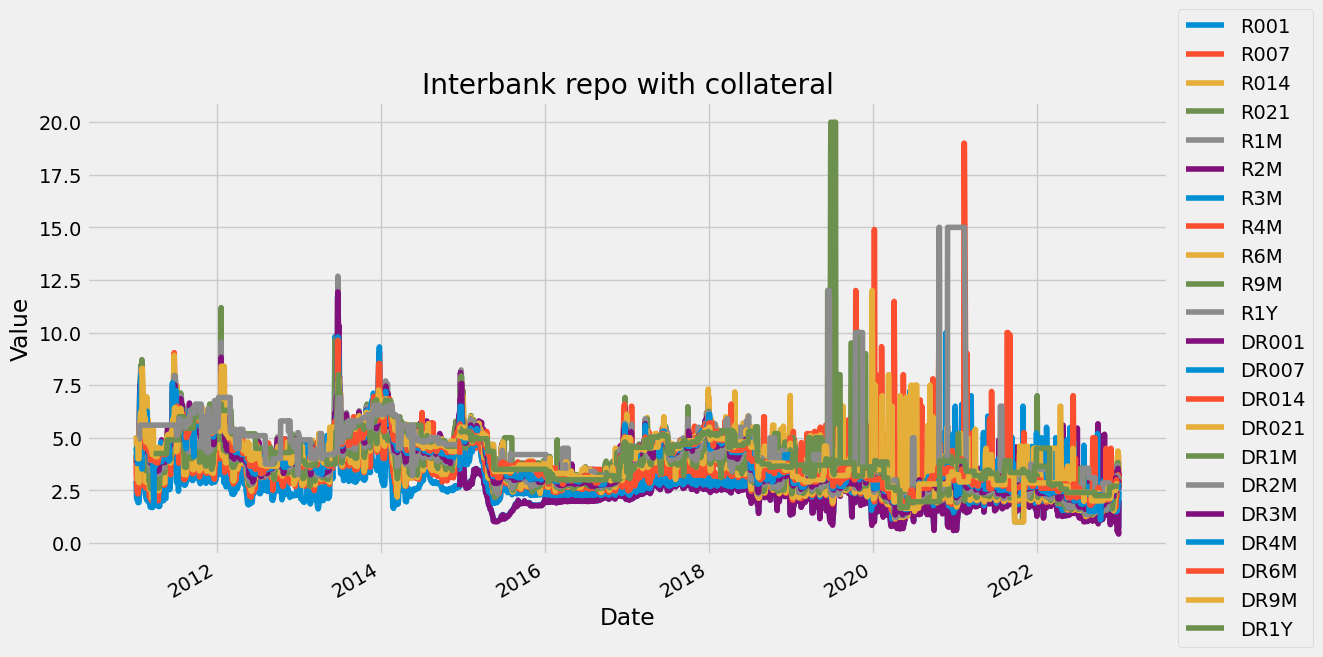

In [10]:
plot_features(interbank_repo_collateral_df, ['R001', 'R007', 'R014', 'R021', 'R1M', 'R2M', 'R3M', 'R4M',
       'R6M', 'R9M', 'R1Y', 'DR001', 'DR007', 'DR014', 'DR021', 'DR1M', 'DR2M',
       'DR3M', 'DR4M', 'DR6M', 'DR9M', 'DR1Y'], title="Interbank repo with collateral")

## 银行间买断式回购

Interbank buy-out repo

In [11]:
raw_interbank_repo_buy_out_df = pd.read_excel("./data/features/银行间买断式回购.xlsx")
raw_interbank_repo_buy_out_df = raw_interbank_repo_buy_out_df.rename(columns={"指标名称": 'Date'})
raw_interbank_repo_buy_out_df

,Date,OR001,OR007,OR014,OR021,OR1M,OR2M,OR3M
0,2004-05-21,NaN,2.1616,2.1517,NaN,NaN,NaN,NaN
1,2004-05-25,NaN,NaN,2.1814,NaN,NaN,NaN,NaN
2,2004-05-27,2.1933,2.1191,NaN,NaN,NaN,NaN,NaN
3,2004-05-28,NaN,NaN,2.3286,NaN,NaN,2.8514,NaN
4,2004-05-31,NaN,NaN,NaN,NaN,2.8031,3.0113,NaN
...,...,...,...,...,...,...,...,...
4664,2023-03-13,1.7024,1.8044,1.8726,NaN,2.2609,NaN,NaN
4665,2023-03-14,1.9753,1.7994,2.0852,NaN,2.8996,NaN,NaN
4666,2023-03-15,2.2573,2.0899,2.3299,NaN,2.3254,NaN,NaN
4667,2023-03-16,2.5601,2.2128,2.3162,NaN,2.9006,NaN,NaN


In [12]:
interbank_repo_buy_out_df = clean_data(raw_interbank_repo_buy_out_df, date_benchmark, feature_start_date, end_date)
interbank_repo_buy_out_df

,Date,OR001,OR007,OR014,OR021,OR1M,OR2M,OR3M
0,2011-01-04,3.0241,4.2675,4.6602,3.2002,NaN,NaN,NaN
1,2011-01-05,2.7831,3.4286,4.5011,3.0753,NaN,4.3999,3.0746
2,2011-01-06,2.2567,3.3557,3.9500,3.1998,NaN,3.9104,3.0746
3,2011-01-07,2.1950,2.9086,3.5010,3.2004,NaN,3.9104,3.0746
4,2011-01-10,2.1224,2.5769,4.3994,3.2004,4.2502,3.9104,3.0746
...,...,...,...,...,...,...,...,...
2986,2022-12-26,0.8625,3.2177,3.5129,4.6492,2.9974,3.6997,2.5498
2987,2022-12-27,0.7069,3.3331,6.7989,4.5010,2.9974,3.6997,2.5498
2988,2022-12-28,0.5656,3.6057,3.8557,3.5003,2.9974,3.1004,2.5498
2989,2022-12-29,0.4875,2.4785,3.8557,3.5003,2.9974,3.0002,2.5498


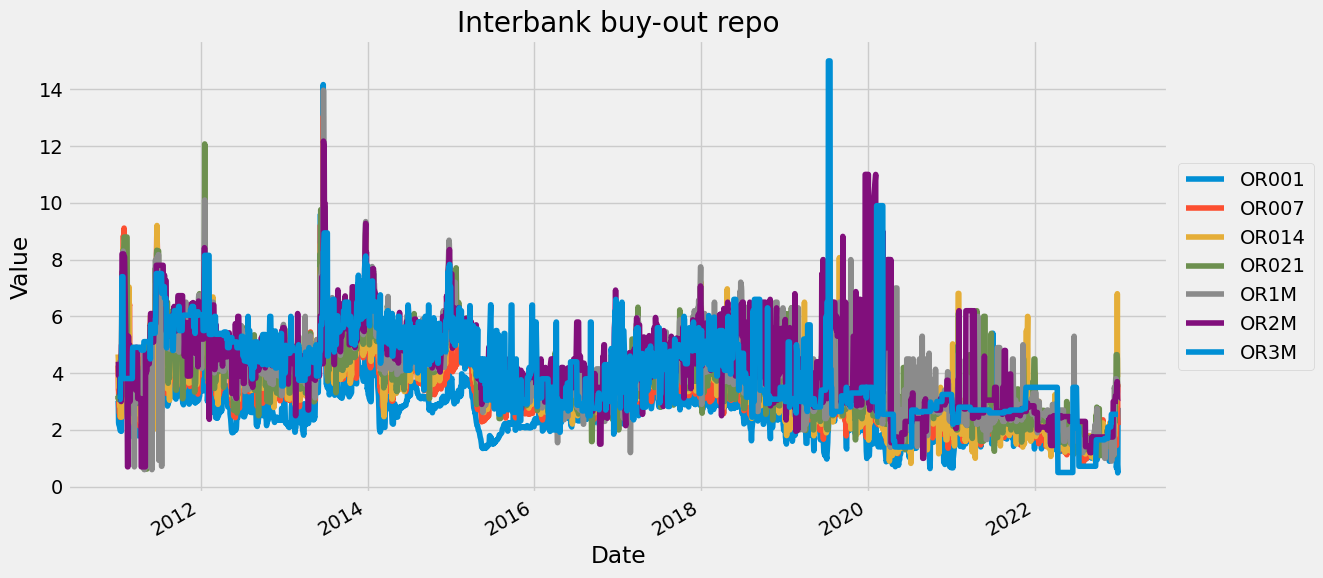

In [13]:
plot_features(interbank_repo_buy_out_df, ['OR001', 'OR007', 'OR014', 'OR021', 'OR1M', 'OR2M', 'OR3M'], title="Interbank buy-out repo")

## 回购定盘利率

Repo fixing rate

In [14]:
raw_repo_fixing_rate_df = pd.read_excel("./data/features/回购定盘利率.xlsx")
raw_repo_fixing_rate_df = raw_repo_fixing_rate_df.rename(columns={"指标名称": 'Date'})
raw_repo_fixing_rate_df

,Date,FR001,FR007,FR014
0,2000-01-04,NaN,2.57,NaN
1,2000-01-05,NaN,2.56,NaN
2,2000-01-06,NaN,2.57,NaN
3,2000-01-07,NaN,2.58,NaN
4,2000-01-10,NaN,2.58,NaN
...,...,...,...,...
5802,2023-03-13,1.67,2.20,2.15
5803,2023-03-14,1.88,2.20,2.15
5804,2023-03-15,2.22,2.25,2.20
5805,2023-03-16,2.45,2.30,2.25


In [15]:
repo_fixing_rate_df = clean_data(raw_repo_fixing_rate_df, date_benchmark, feature_start_date, end_date)
repo_fixing_rate_df

,Date,FR001,FR007,FR014
0,2011-01-04,2.9543,4.3100,4.35
1,2011-01-05,2.6961,3.2600,4.15
2,2011-01-06,2.1998,3.1400,4.10
3,2011-01-07,2.1470,2.8200,3.96
4,2011-01-10,2.0270,2.3780,3.85
...,...,...,...,...
2990,2022-12-26,0.8600,2.0558,3.90
2991,2022-12-27,0.7500,5.0000,3.60
2992,2022-12-28,0.6000,4.8000,3.50
2993,2022-12-29,0.5500,3.5000,3.20


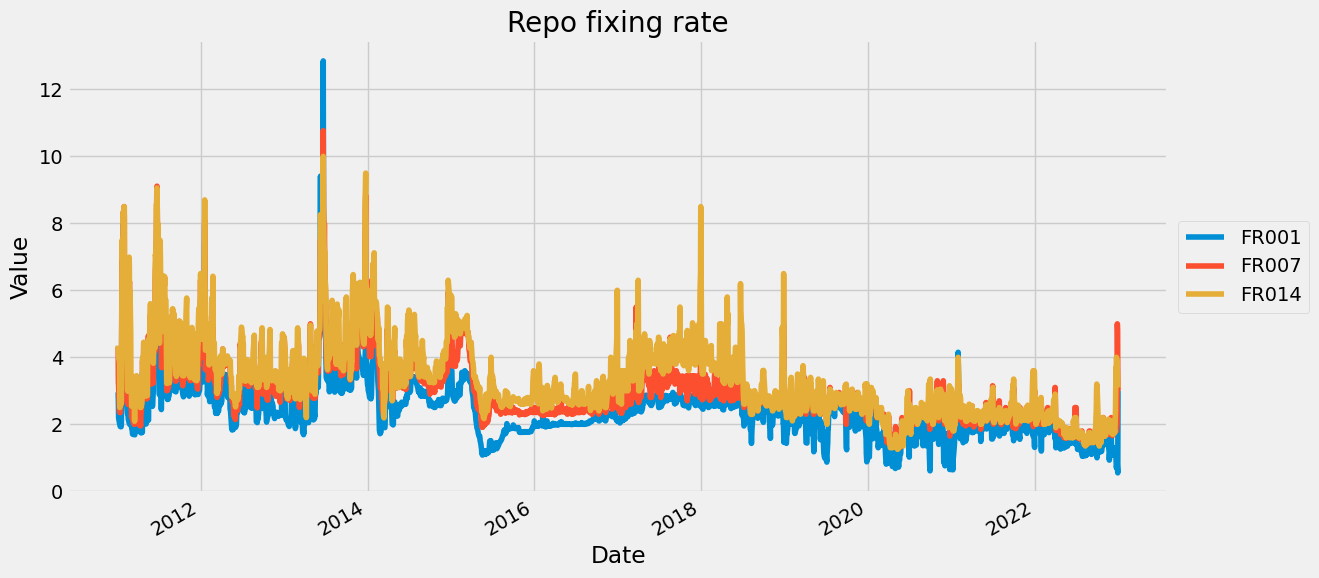

In [16]:
plot_features(repo_fixing_rate_df, ['FR001', 'FR007', 'FR014'], title="Repo fixing rate")

### 银银间回购定盘利率

Interbank repurchase fixing rate

In [17]:
raw_interbank_repurchase_fix_rate_df = pd.read_excel("./data/features/银银间回购定盘利率.xlsx")
raw_interbank_repurchase_fix_rate_df = raw_interbank_repurchase_fix_rate_df.rename(columns={"指标名称": 'Date'})
raw_interbank_repurchase_fix_rate_df

,Date,FDR001,FDR007,FDR014
0,2017-05-31,2.6200,2.66,3.80
1,2017-06-01,2.6400,2.78,3.79
2,2017-06-02,2.8000,2.80,3.85
3,2017-06-05,2.7800,2.72,3.95
4,2017-06-06,2.8300,2.71,3.91
...,...,...,...,...
1443,2023-03-13,1.6196,1.96,2.03
1444,2023-03-14,1.8300,2.07,2.07
1445,2023-03-15,2.1200,2.13,2.18
1446,2023-03-16,2.3098,2.20,2.25


In [18]:
interbank_repurchase_fix_rate_df = clean_data(raw_interbank_repurchase_fix_rate_df, date_benchmark, feature_start_date, end_date)
interbank_repurchase_fix_rate_df

,Date,FDR001,FDR007,FDR014
0,2017-05-31,2.62,2.6600,3.80
1,2017-06-01,2.64,2.7800,3.79
2,2017-06-02,2.80,2.8000,3.85
3,2017-06-05,2.78,2.7200,3.95
4,2017-06-06,2.83,2.7100,3.91
...,...,...,...,...
1392,2022-12-26,0.80,1.9374,3.10
1393,2022-12-27,0.60,1.9870,3.12
1394,2022-12-28,0.51,2.0800,3.19
1395,2022-12-29,0.43,2.3300,3.20


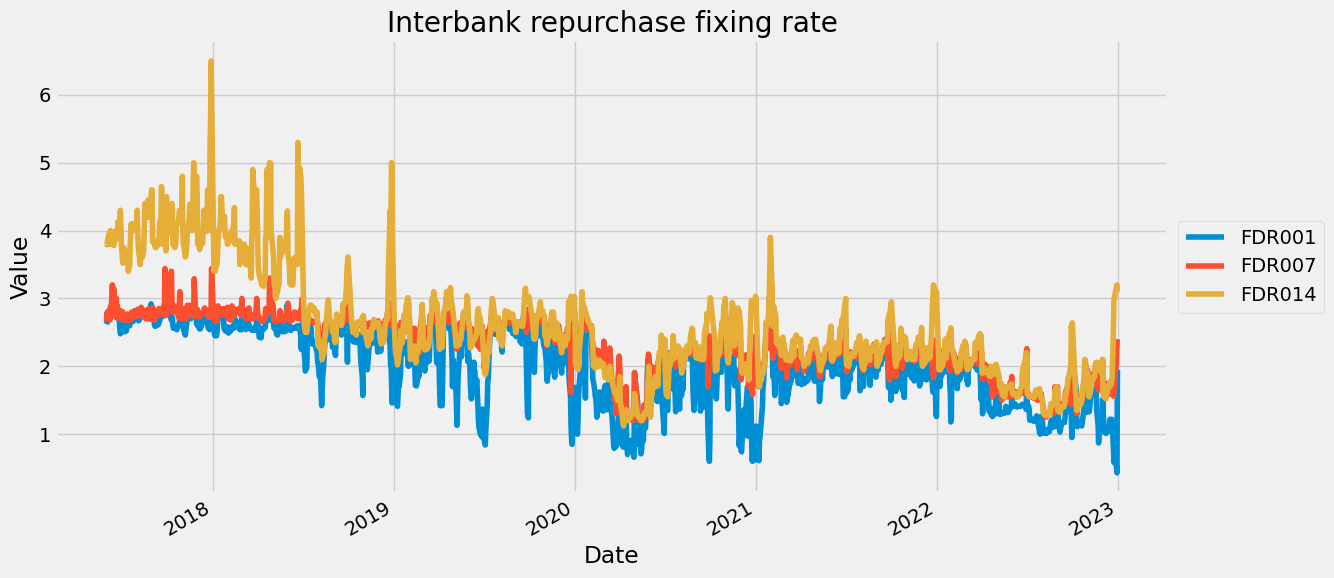

In [19]:
plot_features(interbank_repurchase_fix_rate_df, ['FDR001', 'FDR007', 'FDR014'], title="Interbank repurchase fixing rate")

### 银行间同业拆借

inter-bank offer

In [20]:
raw_inter_bank_offer_df = pd.read_excel("./data/features/银行间同业拆借.xlsx")
raw_inter_bank_offer_df = raw_inter_bank_offer_df.rename(columns={"指标名称": 'Date'})
raw_inter_bank_offer_df

,Date,IBO001,IBO007,IBO014,IBO021,IBO1M,IBO2M,IBO3M,IBO4M,IBO6M,...,DIBO007,DIBO014,DIBO021,DIBO1M,DIBO2M,DIBO3M,DIBO4M,DIBO6M,DIBO9M,DIBO1Y
0,2004-05-24,1.8977,2.2482,2.2750,2.2906,NaN,NaN,3.9778,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-05-25,1.9842,2.1689,2.1399,2.1200,2.7427,3.0500,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004-05-26,1.9055,2.2195,2.1200,2.2500,3.0625,NaN,2.8500,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004-05-27,2.0092,2.1956,NaN,2.2500,1.9852,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004-05-28,1.9714,2.3423,2.0936,NaN,3.3000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701,2023-03-13,1.6859,2.2025,2.3110,2.0000,2.5109,2.6985,2.9204,2.55,2.8233,...,2.0246,2.0104,2.00,2.4711,2.6985,2.9720,2.55,2.8233,2.9758,3.0931
4702,2023-03-14,1.8999,2.3415,2.2873,2.1500,2.4999,NaN,2.9820,NaN,NaN,...,2.0962,2.1274,NaN,2.4401,NaN,2.8582,NaN,NaN,3.1075,3.7400
4703,2023-03-15,2.1947,2.3564,2.3660,2.2100,2.6636,2.8803,3.0347,NaN,2.7987,...,2.1543,2.2136,2.21,2.5857,2.6962,2.8197,NaN,2.7987,NaN,3.5583
4704,2023-03-16,2.3787,2.5291,2.2458,2.9286,3.1882,2.7444,3.0525,NaN,NaN,...,2.2170,2.2637,2.25,2.7429,2.6500,3.1000,NaN,NaN,NaN,3.3467


In [21]:
inter_bank_offer_df = clean_data(raw_inter_bank_offer_df, date_benchmark, feature_start_date, end_date)
inter_bank_offer_df

,Date,IBO001,IBO007,IBO014,IBO021,IBO1M,IBO2M,IBO3M,IBO4M,IBO6M,...,DIBO007,DIBO014,DIBO021,DIBO1M,DIBO2M,DIBO3M,DIBO4M,DIBO6M,DIBO9M,DIBO1Y
0,2011-01-04,2.8474,4.3742,4.5000,NaN,4.1000,4.5000,4.6000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-05,2.6523,3.2866,4.1670,NaN,3.8312,4.5000,4.5575,NaN,4.5500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-06,2.1785,3.2438,4.0872,NaN,4.0545,4.5000,4.4406,NaN,4.4200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-07,2.1161,2.8282,3.7300,NaN,3.9041,4.1508,4.4287,NaN,4.3500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01-10,2.0126,2.3685,4.0000,3.6000,3.7050,4.1508,4.4045,NaN,3.8500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,2022-12-26,0.9085,2.1899,2.9253,2.6400,3.1442,3.1134,2.7811,3.3218,3.1667,...,1.9820,3.0810,2.64,3.4489,3.0733,2.9513,3.3321,3.1667,3.5833,3.6286
2992,2022-12-27,0.7263,2.3459,2.6372,2.9000,2.6364,2.8332,3.1029,5.1500,2.7095,...,1.9996,2.8264,2.90,3.4489,3.1083,3.1931,3.3321,2.7095,3.5833,3.5119
2993,2022-12-28,0.6314,2.4058,3.0557,2.5429,2.9487,2.6693,2.6893,4.0000,2.9264,...,2.1662,3.0801,3.20,3.0619,2.7794,2.5309,3.3321,2.9264,3.5833,4.0056
2994,2022-12-29,0.5767,2.6234,3.3428,2.7803,2.8004,2.8407,2.5975,4.0000,3.7542,...,2.5416,3.3428,3.35,2.8496,2.9500,2.5263,3.3321,3.7542,3.5833,3.3769


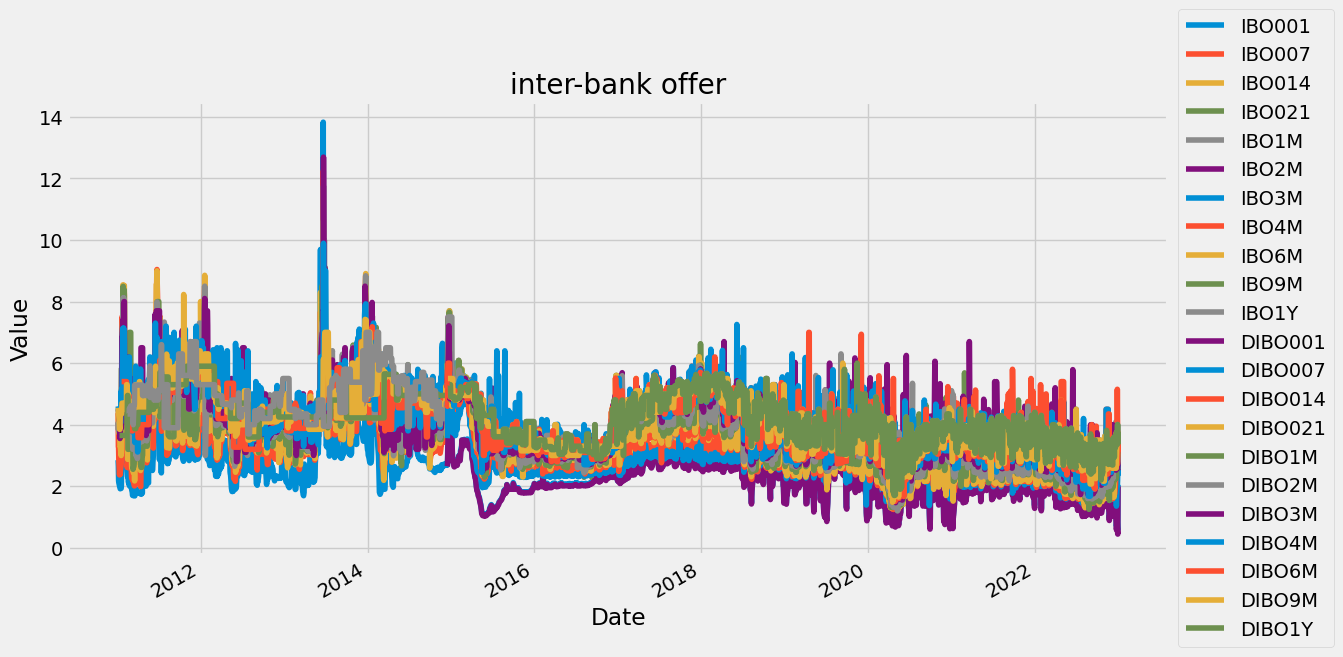

In [22]:
plot_features(inter_bank_offer_df, ['IBO001', 'IBO007', 'IBO014', 'IBO021', 'IBO1M', 'IBO2M',
       'IBO3M', 'IBO4M', 'IBO6M', 'IBO9M', 'IBO1Y', 'DIBO001', 'DIBO007',
       'DIBO014', 'DIBO021', 'DIBO1M', 'DIBO2M', 'DIBO3M', 'DIBO4M', 'DIBO6M',
       'DIBO9M', 'DIBO1Y'], title="inter-bank offer")

### SHIBOR

In [23]:
raw_shibor_df = pd.read_excel("./data/features/SHIBOR.xlsx")
raw_shibor_df = raw_shibor_df.rename(columns={"指标名称": 'Date'})
raw_shibor_df

,Date,SHIBORO/N,SHIBOR1W,SHIBOR2W,SHIBOR1M,SHIBOR3M,SHIBOR6M,SHIBOR9M,SHIBOR1Y
0,2006-10-08,2.1184,2.2930,2.3848,2.5319,2.6110,2.7404,2.8521,2.9543
1,2006-10-09,2.0990,2.2960,2.3972,2.5522,2.6248,2.7431,2.8514,2.9549
2,2006-10-10,2.0922,2.2971,2.4236,2.5739,2.6325,2.7454,2.8544,2.9531
3,2006-10-11,2.0955,2.2932,2.4930,2.5864,2.6338,2.7475,2.8547,2.9559
4,2006-10-12,2.0943,2.2904,2.5240,2.5900,2.6380,2.7470,2.8570,2.9550
...,...,...,...,...,...,...,...,...,...
4104,2023-03-13,1.6140,1.9590,2.0090,2.3710,2.4980,2.5980,2.6710,2.7490
4105,2023-03-14,1.8290,2.0550,2.0660,2.3780,2.4990,2.5980,2.6720,2.7460
4106,2023-03-15,2.1090,2.0890,2.1800,2.3840,2.5000,2.5980,2.6730,2.7450
4107,2023-03-16,2.2940,2.1770,2.2340,2.3900,2.5000,2.6000,2.6690,2.7440


In [24]:
shibor_df = clean_data(raw_shibor_df, date_benchmark, feature_start_date, end_date)
shibor_df

,Date,SHIBORO/N,SHIBOR1W,SHIBOR2W,SHIBOR1M,SHIBOR3M,SHIBOR6M,SHIBOR9M,SHIBOR1Y
0,2011-01-04,2.9308,4.3108,4.3692,4.4711,4.5583,3.5598,3.5978,3.6383
1,2011-01-05,2.6800,3.2192,4.1208,4.1676,4.5220,3.5789,3.6076,3.6461
2,2011-01-06,2.1804,3.1567,4.0775,4.1188,4.4648,3.5806,3.6152,3.6521
3,2011-01-07,2.1200,2.7996,3.8800,3.9565,4.4184,3.6009,3.6353,3.6620
4,2011-01-10,2.0100,2.3725,3.8417,3.9007,4.3408,3.6113,3.6497,3.6774
...,...,...,...,...,...,...,...,...,...
2990,2022-12-26,0.8200,1.9610,3.0390,2.3060,2.4050,2.4940,2.5500,2.6230
2991,2022-12-27,0.6320,2.0040,3.0840,2.3210,2.4110,2.4980,2.5540,2.6200
2992,2022-12-28,0.5220,2.0190,3.1900,2.3320,2.4160,2.5040,2.5580,2.6200
2993,2022-12-29,0.4410,2.2610,3.1650,2.3400,2.4180,2.5050,2.5610,2.6190


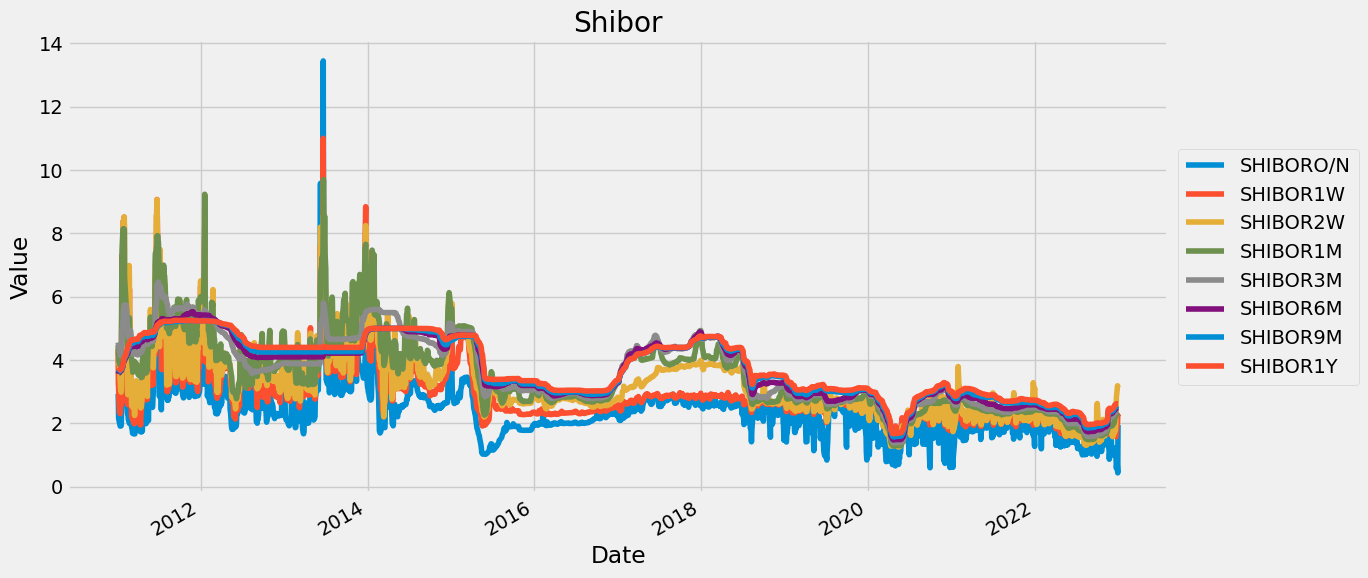

In [25]:
plot_features(shibor_df, ['SHIBORO/N', 'SHIBOR1W', 'SHIBOR2W', 'SHIBOR1M', 'SHIBOR3M',
       'SHIBOR6M', 'SHIBOR9M', 'SHIBOR1Y'], title="Shibor")

### 5年期国债期货IRR

5 year Treasury futures IRR

In [26]:
raw_future_irr_5Y = pd.read_excel("./data/features/5年期国债期货IRR.xlsx")
raw_future_irr_5Y = raw_future_irr_5Y.rename(columns={
    '指标名称': 'Date', '5年期国债期货IRR:本季': "5Y_IRR", '5年期国债期货基差:本季': "5Y_Spread_IRR", 
    '5年期国债期货IRR:次季': "5Y_IRR_Second", '5年期国债期货基差:次季': "5Y_Spread_IRR_Second", 
    '5年期国债期货IRR:远季': "5Y_IRR_Far", '5年期国债期货基差:远季': "5Y_Spread_IRR_Far"})
raw_future_irr_5Y

,Date,5Y_IRR,5Y_Spread_IRR,5Y_IRR_Second,5Y_Spread_IRR_Second,5Y_IRR_Far,5Y_Spread_IRR_Far
0,2013-09-06,3.6851,-0.0345,3.6999,-0.0728,3.6046,-0.0351
1,2013-09-09,3.0491,0.1350,3.3422,0.1107,3.3788,0.0978
2,2013-09-10,3.7638,-0.0502,3.6658,-0.0479,3.6342,-0.0474
3,2013-09-11,3.3424,0.0178,3.4334,-0.0106,3.6008,-0.0486
4,2013-09-12,4.3398,-0.2347,4.0328,-0.3057,3.9902,-0.3232
...,...,...,...,...,...,...,...
2311,2023-03-13,1.3192,0.2950,1.1727,0.8593,1.1977,1.2925
2312,2023-03-14,1.5167,0.2421,1.2346,0.8229,1.2600,1.2411
2313,2023-03-15,1.2990,0.2936,1.2651,0.8034,1.2879,1.2166
2314,2023-03-16,1.7665,0.1684,1.3825,0.7393,1.3339,1.1774


In [27]:
future_irr_5Y = clean_data(raw_future_irr_5Y, date_benchmark, feature_start_date, end_date)
future_irr_5Y

,Date,5Y_IRR,5Y_Spread_IRR,5Y_IRR_Second,5Y_Spread_IRR_Second,5Y_IRR_Far,5Y_Spread_IRR_Far
0,2013-09-06,3.6851,-0.0345,3.6999,-0.0728,3.6046,-0.0351
1,2013-09-09,3.0491,0.1350,3.3422,0.1107,3.3788,0.0978
2,2013-09-10,3.7638,-0.0502,3.6658,-0.0479,3.6342,-0.0474
3,2013-09-11,3.3424,0.0178,3.4334,-0.0106,3.6008,-0.0486
4,2013-09-12,4.3398,-0.2347,4.0328,-0.3057,3.9902,-0.3232
...,...,...,...,...,...,...,...
2262,2022-12-26,2.1961,0.1596,1.6909,0.6098,1.7275,0.8282
2263,2022-12-27,0.3829,0.4465,0.8522,0.7574,0.8819,1.4292
2264,2022-12-28,1.1032,0.2904,1.1727,0.6062,1.0061,1.4110
2265,2022-12-29,1.5365,0.1973,1.3585,0.5179,1.0516,1.2964


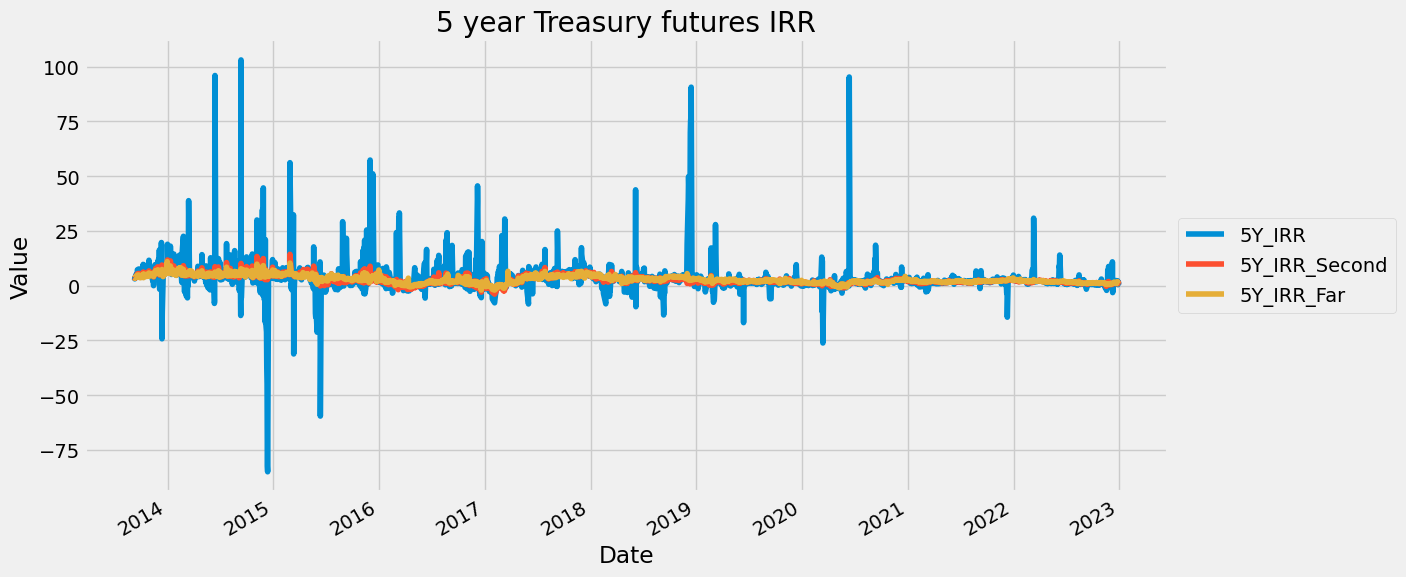

In [28]:
plot_features(future_irr_5Y, [ '5Y_IRR', '5Y_IRR_Second',
        '5Y_IRR_Far'], title="5 year Treasury futures IRR")

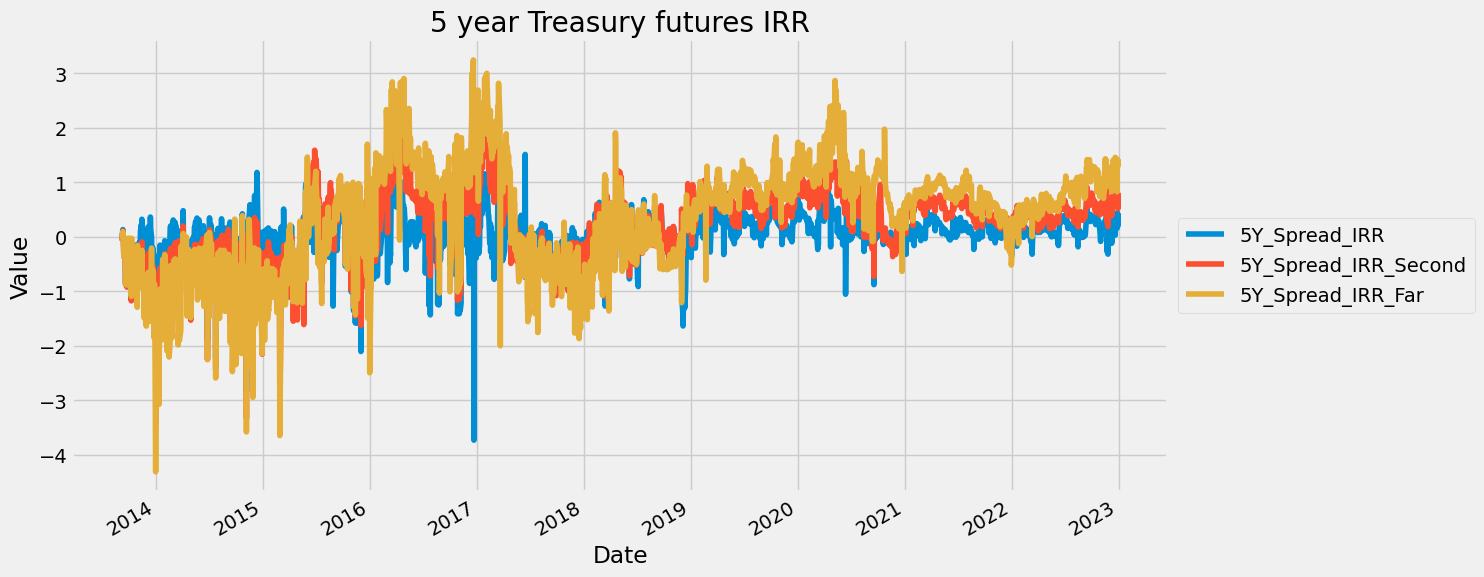

In [29]:
plot_features(future_irr_5Y, [ '5Y_Spread_IRR', 
       '5Y_Spread_IRR_Second', '5Y_Spread_IRR_Far'], title="5 year Treasury futures IRR")

In [30]:
#Monetary and fiscal policy
result_df = date_benchmark

data_frames = [interbank_repo_collateral_df, interbank_repo_buy_out_df,
                repo_fixing_rate_df, interbank_repurchase_fix_rate_df,
                inter_bank_offer_df, shibor_df,
                future_irr_5Y,
                ]
for temp in data_frames:
    result_df = result_df.merge(temp, on="Date", how="left")
result_df

,Date,R001,R007,R014,R021,R1M,R2M,R3M,R4M,R6M,...,SHIBOR3M,SHIBOR6M,SHIBOR9M,SHIBOR1Y,5Y_IRR,5Y_Spread_IRR,5Y_IRR_Second,5Y_Spread_IRR_Second,5Y_IRR_Far,5Y_Spread_IRR_Far
0,2011-01-04,2.9465,4.1937,4.1284,NaN,4.1104,NaN,4.4333,NaN,5.1000,...,4.5583,3.5598,3.5978,3.6383,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-05,2.6765,3.1877,4.1092,NaN,3.9979,3.9358,4.4790,NaN,4.9429,...,4.5220,3.5789,3.6076,3.6461,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-06,2.1745,3.0859,3.9631,4.8604,3.9141,3.9165,4.3777,4.4700,4.8000,...,4.4648,3.5806,3.6152,3.6521,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-07,2.1035,2.8052,3.9519,3.9000,3.7896,3.9322,4.0170,4.4700,4.6817,...,4.4184,3.6009,3.6353,3.6620,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01-10,2.0032,2.3842,3.9067,3.7776,3.8296,3.9628,4.0095,4.4700,4.6943,...,4.3408,3.6113,3.6497,3.6774,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,2022-12-26,0.9810,3.7635,4.3731,3.8204,3.3336,3.5420,2.8589,2.6000,3.0500,...,2.4050,2.4940,2.5500,2.6230,2.1961,0.1596,1.6909,0.6098,1.7275,0.8282
2989,2022-12-27,0.8456,4.2408,4.3009,3.5623,3.3366,3.4890,2.8063,2.8000,3.0000,...,2.4110,2.4980,2.5540,2.6200,0.3829,0.4465,0.8522,0.7574,0.8819,1.4292
2990,2022-12-28,0.7522,4.1526,3.9042,3.1174,3.0962,3.3374,2.9199,2.6786,3.0000,...,2.4160,2.5040,2.5580,2.6200,1.1032,0.2904,1.1727,0.6062,1.0061,1.4110
2991,2022-12-29,0.7440,3.3101,3.2013,2.6469,3.0345,3.1820,2.5000,2.7600,3.0000,...,2.4180,2.5050,2.5610,2.6190,1.5365,0.1973,1.3585,0.5179,1.0516,1.2964


In [31]:
result_df.to_csv("./data/clean_features/features_interest_rate_transmission.csv", index=False, encoding="utf-8-sig")

In [32]:
result_df.describe()

,R001,R007,R014,R021,R1M,R2M,R3M,R4M,R6M,R9M,...,SHIBOR3M,SHIBOR6M,SHIBOR9M,SHIBOR1Y,5Y_IRR,5Y_Spread_IRR,5Y_IRR_Second,5Y_Spread_IRR_Second,5Y_IRR_Far,5Y_Spread_IRR_Far
count,2993.000000,2993.000000,2993.000000,2991.000000,2993.000000,2992.000000,2993.000000,2991.000000,2993.000000,2940.000000,...,2993.000000,2993.000000,2993.000000,2993.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000
mean,2.424740,3.027023,3.379460,3.636120,3.718913,3.902923,3.929101,4.071609,4.167394,4.285118,...,3.621276,3.648221,3.716275,3.785931,3.262079,0.042082,2.637481,0.229803,2.784052,0.368280
std,0.901985,1.012587,1.131788,1.213525,1.243951,1.176149,1.170439,1.389814,1.221620,1.671974,...,1.133112,1.011524,0.966378,0.953777,8.112841,0.430277,1.978952,0.675859,1.696866,0.951991
min,0.677900,1.257000,1.347800,1.276800,1.391700,1.486500,1.362900,1.100000,1.441300,1.000000,...,1.391000,1.480000,1.572000,1.674000,-85.056500,-3.732300,-3.921800,-3.404000,-2.094000,-4.312300
25%,1.913900,2.381000,2.594500,2.753150,2.803400,3.029675,3.000500,3.097900,3.200000,3.200000,...,2.760000,2.858000,2.959000,3.042000,0.984150,-0.102300,1.364750,-0.193900,1.645950,-0.359200
50%,2.317300,2.803400,3.125800,3.356500,3.433600,3.713200,3.771700,4.000000,4.100000,4.300000,...,3.233700,3.346000,3.505000,3.550000,2.120900,0.073800,2.128100,0.348200,2.337800,0.552200
75%,2.805500,3.467100,3.957500,4.400000,4.484000,4.630325,4.688200,4.900000,5.000000,5.000000,...,4.649500,4.456000,4.552300,4.643000,4.325300,0.259100,3.978950,0.643600,4.099800,0.997450
max,11.743600,11.621700,9.262600,11.186000,12.677300,11.933400,10.000000,19.000000,12.000000,20.000000,...,6.461100,5.524200,5.250200,5.256200,103.031400,1.890300,14.271400,2.718900,10.925500,3.248500
